# DEA Coastlines summary plots

In [1]:
cd ../'Tools'

/home/jovyan/dev/dea-notebooks/Tools


In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from dea_tools.coastal import get_coastlines

from scipy.stats import ttest_ind
from scipy.stats import ttest_rel

## Load data

In [86]:
# Set study area from vector file

## Use regions_gdf for mainland polygons
regions_gdf = (
    gpd.read_file(
        # "https://data.dea.ga.gov.au/derivative/dea_coastlines/supplementary/australia_mainland_regions.geojson"
        # '/home/jovyan/dev/dea-notebooks/Testing/Buffered_GBR_mngt_areas.shp' ## Management area polygons
        # '/home/jovyan/dev/dea-notebooks/Testing/Manual_all_GBR_Coastlines.shp' ## Greater GBR extent
        # '/home/jovyan/dev/dea-notebooks/Testing/Aus_bbox.shp' ## 
        '/home/jovyan/dev/dea-notebooks/Testing/mainland_buffered_edited_mngt_regions_incl_allGBR.shp' ## all mainland only extents
    )
    # .set_index("Descriptio")
    .set_index("layer")
    # .set_index('id')
)
# regions_gdf

In [87]:
## Use regions_gdf_offshore for island and reef polygons
regions_gdf_offshore = (
    gpd.read_file(
        # "https://data.dea.ga.gov.au/derivative/dea_coastlines/supplementary/australia_mainland_regions.geojson"
        # '/home/jovyan/dev/dea-notebooks/Testing/Buffered_GBR_mngt_areas.shp' ## Management area polygons
        # '/home/jovyan/dev/dea-notebooks/Testing/Manual_all_GBR_Coastlines.shp' ## Greater GBR extent
        '/home/jovyan/dev/dea-notebooks/Testing/islands_management_regions_incl_allGBR.shp' ## all reef and island extents
    )
    
    
    # .set_index("Descriptio")
    # .set_index("layer")
    .set_index('AREA_DESCR')
)
# regions_gdf_offshore


In [88]:
print(regions_gdf.index)
print(regions_gdf_offshore.index)

Index(['Manual_all_GBR_Coastlines_area1', 'Manual_all_GBR_Coastlines_area2',
       'Manual_all_GBR_Coastlines_area3', 'Manual_all_GBR_Coastlines_area4',
       'buffered_GBR_features_mainland'],
      dtype='object', name='layer')
Index(['All_GBR_offshore', 'Mackay/Capricorn Management Area',
       'Townsville/Whitsunday Management Area',
       'Cairns/Cooktown Management Area', 'Far Northern Management Area'],
      dtype='object', name='AREA_DESCR')


In [307]:
study_area = regions_gdf.loc[["buffered_GBR_features_mainland"]]
study_area_offshore = regions_gdf_offshore.loc[['All_GBR_offshore']]
# study_area = regions_gdf.loc[["1"]]
# study_area = regions_gdf

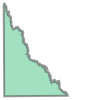

In [308]:
study_area.geometry[0]

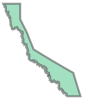

In [309]:
study_area_offshore.geometry[0]

In [311]:
# Load data from WFS for study area bounding box
bbox = study_area.geometry.bounds.values[0]
# bbox = study_area.geometry.bounds#.values[0]
ratesofchange_gdf = get_coastlines(
    bbox=bbox, layer="rates_of_change"
)

# Clip returned data to polygon extent
ratesofchange_gdf = gpd.clip(ratesofchange_gdf, mask=study_area.to_crs("EPSG:3577"))
ratesofchange_gdf.head()

,id,uid,rate_time,sig_time,se_time,outl_time,dist_1988,dist_1989,dist_1990,dist_1991,...,angle_std,valid_obs,valid_span,sce,nsm,max_year,min_year,certainty,id_primary,geometry
313218,rates_of_change.1199310,r7shs40400,-8.70,0.0,1.05,None,243.84,257.19,235.64,254.61,...,26,35,35,341.60,-243.84,2003,2022,good,QLD15,POINT (2001372.310 -2805070.488)
313219,rates_of_change.1199311,r7shefpgxe,-8.12,0.0,1.03,None,224.63,234.44,215.48,232.02,...,28,35,35,325.46,-224.63,2004,2022,good,QLD15,POINT (2001375.044 -2805040.271)
313220,rates_of_change.1199312,r7shefpvpj,-7.54,0.0,1.04,None,205.50,213.51,196.48,210.39,...,29,35,35,337.19,-205.50,2004,2022,good,QLD15,POINT (2001377.682 -2805010.046)
313221,rates_of_change.1199313,r7shefpytw,-6.88,0.0,1.04,None,189.22,196.83,181.04,192.29,...,30,35,35,323.76,-189.22,2004,2022,good,QLD15,POINT (2001375.729 -2804979.805)
313222,rates_of_change.1199314,r7shefrbq8,-6.31,0.0,1.07,None,164.74,171.99,156.06,166.33,...,32,35,35,307.65,-164.74,2004,2020,high angular variability,QLD15,POINT (2001385.314 -2804951.089)


In [312]:
## Repeat for offshore polygon

# Load data from WFS for study area bounding box
bbox_offshore = study_area_offshore.geometry.bounds.values[0]
# bbox = study_area.geometry.bounds#.values[0]
ratesofchange_gdf_offshore = get_coastlines(
    bbox=bbox_offshore, layer="rates_of_change"
)

# Clip returned data to polygon extent
ratesofchange_gdf_offshore = gpd.clip(ratesofchange_gdf_offshore, mask=study_area_offshore.to_crs("EPSG:3577"))
ratesofchange_gdf_offshore.head()

,id,uid,rate_time,sig_time,se_time,outl_time,dist_1988,dist_1989,dist_1990,dist_1991,...,angle_std,valid_obs,valid_span,sce,nsm,max_year,min_year,certainty,id_primary,geometry
307773,rates_of_change.1192178,r7swg1dybe,0.37,0.0,0.04,None,-10.86,-11.36,-11.29,-5.71,...,4,35,35,16.04,10.86,2015,1996,good,QLD15,POINT (2074091.842 -2772129.834)
307775,rates_of_change.1192180,r7swg1dzr2,0.42,0.0,0.06,None,-9.29,-12.62,-11.94,-7.72,...,6,35,35,19.94,9.29,2015,1995,good,QLD15,POINT (2074121.402 -2772126.650)
307776,rates_of_change.1192181,r7swg1ep6v,0.47,0.0,0.06,None,-12.72,-16.37,-13.16,-7.29,...,8,35,35,20.98,12.72,2014,1995,good,QLD15,POINT (2074136.317 -2772125.899)
307774,rates_of_change.1192179,r7swg1dwcz,0.34,0.0,0.07,None,-6.86,-9.98,-9.82,0.48,...,5,35,35,21.90,6.86,2014,1996,good,QLD15,POINT (2074063.296 -2772122.585)
307779,rates_of_change.1192184,r7swg1g20v,0.36,0.0,0.06,None,-9.00,-13.96,-7.89,-2.53,...,6,35,35,21.99,9.00,2014,1989,good,QLD15,POINT (2074164.451 -2772116.320)


In [313]:
## Epoch based change
### NOTE: there are three places in this code cell where epoch dates need to be adjusted

## Create a linear regression object
linear_regressor = LinearRegression()

## Set the dates (add 1 to your end date)
x=np.arange(2019, 2023, 1).reshape(-1,1) 

## Define the function to take each row of the gdf and calculate the linear regression 
## coefficient for the time period of interest
def epoch_rate_time(x,y,linear_regressor):
    
    try:
        # If Nans in 'y', remove them and their equivalent indexed values from 'x'
        if pd.isnull(y).any() == True:
            x= np.delete(x, np.argwhere(y.values!=y.values).flatten(order='C')).reshape(-1,1)
            y= y.dropna().values
        else:
            y = y.values
        # Calculate the linear regression
        linear_regressor.fit(x,y)
        # Return only the coefficient into the gdf
        return linear_regressor.coef_[0]
    except:
        print(f'An exception error occurred at {y.id}')

### rename gdf column to match input dates and adjust slices to match exact input and output years
ratesofchange_gdf['2019-2022_epoch_rate_time'] = ratesofchange_gdf.apply(lambda y: epoch_rate_time(x,       
                                                                                                     y.loc['dist_2019':'dist_2022'],  
                                                                                                     linear_regressor), axis=1)
ratesofchange_gdf.head()

,id,uid,rate_time,sig_time,se_time,outl_time,dist_1988,dist_1989,dist_1990,dist_1991,...,valid_obs,valid_span,sce,nsm,max_year,min_year,certainty,id_primary,geometry,2019-2022_epoch_rate_time
313218,rates_of_change.1199310,r7shs40400,-8.70,0.0,1.05,None,243.84,257.19,235.64,254.61,...,35,35,341.60,-243.84,2003,2022,good,QLD15,POINT (2001372.310 -2805070.488),-12.100
313219,rates_of_change.1199311,r7shefpgxe,-8.12,0.0,1.03,None,224.63,234.44,215.48,232.02,...,35,35,325.46,-224.63,2004,2022,good,QLD15,POINT (2001375.044 -2805040.271),-8.415
313220,rates_of_change.1199312,r7shefpvpj,-7.54,0.0,1.04,None,205.50,213.51,196.48,210.39,...,35,35,337.19,-205.50,2004,2022,good,QLD15,POINT (2001377.682 -2805010.046),-4.051
313221,rates_of_change.1199313,r7shefpytw,-6.88,0.0,1.04,None,189.22,196.83,181.04,192.29,...,35,35,323.76,-189.22,2004,2022,good,QLD15,POINT (2001375.729 -2804979.805),-2.217
313222,rates_of_change.1199314,r7shefrbq8,-6.31,0.0,1.07,None,164.74,171.99,156.06,166.33,...,35,35,307.65,-164.74,2004,2020,high angular variability,QLD15,POINT (2001385.314 -2804951.089),3.195


In [314]:
## Repeat for offshore polygons
## Epoch based change
### NOTE: there are three places in this code cell where epoch dates need to be adjusted

# ## Create a linear regression object
# linear_regressor = LinearRegression()

# ## Set the dates (add 1 to your end date)
# x=np.arange(2019, 2023, 1).reshape(-1,1) 

# ## Define the function to take each row of the gdf and calculate the linear regression 
# ## coefficient for the time period of interest
# def epoch_rate_time(x,y,linear_regressor):
    
#     try:
#         # If Nans in 'y', remove them and their equivalent indexed values from 'x'
#         if pd.isnull(y).any() == True:
#             x= np.delete(x, np.argwhere(y.values!=y.values).flatten(order='C')).reshape(-1,1)
#             y= y.dropna().values
#         else:
#             y = y.values
#         # Calculate the linear regression
#         linear_regressor.fit(x,y)
#         # Return only the coefficient into the gdf
#         return linear_regressor.coef_[0]
#     except:
#         print(f'An exception error occurred at {y.id}')

### rename gdf column to match input dates and adjust slices to match exact input and output years
ratesofchange_gdf_offshore['2019-2022_epoch_rate_time'] = ratesofchange_gdf_offshore.apply(lambda y: epoch_rate_time(x,       
                                                                                                     y.loc['dist_2019':'dist_2022'],  
                                                                                                     linear_regressor), axis=1)
ratesofchange_gdf_offshore.head()

,id,uid,rate_time,sig_time,se_time,outl_time,dist_1988,dist_1989,dist_1990,dist_1991,...,valid_obs,valid_span,sce,nsm,max_year,min_year,certainty,id_primary,geometry,2019-2022_epoch_rate_time
307773,rates_of_change.1192178,r7swg1dybe,0.37,0.0,0.04,None,-10.86,-11.36,-11.29,-5.71,...,35,35,16.04,10.86,2015,1996,good,QLD15,POINT (2074091.842 -2772129.834),0.846
307775,rates_of_change.1192180,r7swg1dzr2,0.42,0.0,0.06,None,-9.29,-12.62,-11.94,-7.72,...,35,35,19.94,9.29,2015,1995,good,QLD15,POINT (2074121.402 -2772126.650),0.391
307776,rates_of_change.1192181,r7swg1ep6v,0.47,0.0,0.06,None,-12.72,-16.37,-13.16,-7.29,...,35,35,20.98,12.72,2014,1995,good,QLD15,POINT (2074136.317 -2772125.899),1.101
307774,rates_of_change.1192179,r7swg1dwcz,0.34,0.0,0.07,None,-6.86,-9.98,-9.82,0.48,...,35,35,21.90,6.86,2014,1996,good,QLD15,POINT (2074063.296 -2772122.585),0.467
307779,rates_of_change.1192184,r7swg1g20v,0.36,0.0,0.06,None,-9.00,-13.96,-7.89,-2.53,...,35,35,21.99,9.00,2014,1989,good,QLD15,POINT (2074164.451 -2772116.320),0.727


In [315]:
# ## Temp: compare my method to Robbi's

# # Optional: Keep only rates of change points with "good" certainty 
# # (i.e. no poor quality flags)
# ratesofchange_gdf = ratesofchange_gdf.query("certainty == 'good'")

# ratesofchange_gdf['1988-2022_epoch_rate_time'] = ratesofchange_gdf['1988-2022_epoch_rate_time'].round(2)

# ratesofchange_gdf[['rate_time','1988-2022_epoch_rate_time', '2014-2018_epoch_rate_time','2019-2022_epoch_rate_time']]

In [316]:
# ## Temp: compare my method to Robbi's
# ## Noise possibly caused by my method not removing outliers
# plt.scatter(ratesofchange_gdf.rate_time, ratesofchange_gdf['1988-2022_epoch_rate_time'])

## Data prep

In [317]:
# Optional: Keep only rates of change points with "good" certainty 
# (i.e. no poor quality flags)
ratesofchange_gdf = ratesofchange_gdf.query("certainty == 'good'")

# Optional: Apply correction factor from Bishop-Taylor et al. 2021
ratesofchange_gdf.rate_time += 0.08

# ratesofchange_gdf['2014-2022_epoch_rate_time']+= 0.08
# ratesofchange_gdf['2014-2017_epoch_rate_time']+= 0.08
# ratesofchange_gdf['1988-2022_epoch_rate_time']+= 0.08
# ratesofchange_gdf['2014-2018_epoch_rate_time']+= 0.08
ratesofchange_gdf['2019-2022_epoch_rate_time']+= 0.08

# Add x and y coords to data
ratesofchange_gdf["y_coord"] = ratesofchange_gdf.geometry.y
ratesofchange_gdf["x_coord"] = ratesofchange_gdf.geometry.x

In [318]:
## Repeat for offshore polygons
# Optional: Keep only rates of change points with "good" certainty 
# (i.e. no poor quality flags)
ratesofchange_gdf_offshore = ratesofchange_gdf_offshore.query("certainty == 'good'")

# Optional: Apply correction factor from Bishop-Taylor et al. 2021
ratesofchange_gdf_offshore.rate_time += 0.08

# ratesofchange_gdf['2014-2022_epoch_rate_time']+= 0.08
# ratesofchange_gdf['2014-2017_epoch_rate_time']+= 0.08
# ratesofchange_gdf['1988-2022_epoch_rate_time']+= 0.08
# ratesofchange_gdf['2014-2018_epoch_rate_time']+= 0.08
ratesofchange_gdf_offshore['2019-2022_epoch_rate_time']+= 0.08

# Add x and y coords to data
ratesofchange_gdf_offshore["y_coord"] = ratesofchange_gdf_offshore.geometry.y
ratesofchange_gdf_offshore["x_coord"] = ratesofchange_gdf_offshore.geometry.x

In [319]:
## Temp
# ratesofchange_gdf#['2014-2017_epoch_rate_time'] 

In [320]:
# Replace with 0 all rates with 'sig_time' > 0.01

# Make a copy of the column of interest
ratesofchange_gdf['2019-2022_epoch_rate_time_sig_filtered'] = ratesofchange_gdf['2019-2022_epoch_rate_time']

## Replace with 0 all values where sig_time > 0.01
ratesofchange_gdf.loc[ratesofchange_gdf['sig_time'] > 0.01, '2019-2022_epoch_rate_time_sig_filtered'] = 0
# ratesofchange_gdf[['sig_time', '2019-2022_epoch_rate_time','2019-2022_epoch_rate_time_sig_filtered']] 

## Repeat for all-time change rates
ratesofchange_gdf['rate_time_sig_filtered'] = ratesofchange_gdf['rate_time']

## Replace with 0 all values where sig_time > 0.01
ratesofchange_gdf.loc[ratesofchange_gdf['sig_time'] > 0.01, 'rate_time_sig_filtered'] = 0
ratesofchange_gdf[['sig_time', 'rate_time','rate_time_sig_filtered']] 

,sig_time,rate_time,rate_time_sig_filtered
313218,0.000,-8.62,-8.62
313219,0.000,-8.04,-8.04
313220,0.000,-7.46,-7.46
313221,0.000,-6.80,-6.80
313156,0.660,0.05,0.00
...,...,...,...
120347,0.021,-0.17,0.00
120349,0.031,-0.15,0.00
120351,0.246,-0.02,0.00
120363,0.107,0.20,0.00


In [321]:
## Repeat for offshore polygons
# Replace with 0 all rates with 'sig_time' > 0.01

# Make a copy of the column of interest
ratesofchange_gdf_offshore['2019-2022_epoch_rate_time_sig_filtered'] = ratesofchange_gdf_offshore['2019-2022_epoch_rate_time']

## Replace with 0 all values where sig_time > 0.01
ratesofchange_gdf_offshore.loc[ratesofchange_gdf_offshore['sig_time'] > 0.01, '2019-2022_epoch_rate_time_sig_filtered'] = 0
# ratesofchange_gdf[['sig_time', '2019-2022_epoch_rate_time','2019-2022_epoch_rate_time_sig_filtered']] 

## Repeat for all-time change rates
ratesofchange_gdf_offshore['rate_time_sig_filtered'] = ratesofchange_gdf_offshore['rate_time']

## Replace with 0 all values where sig_time > 0.01
ratesofchange_gdf_offshore.loc[ratesofchange_gdf_offshore['sig_time'] > 0.01, 'rate_time_sig_filtered'] = 0
ratesofchange_gdf_offshore[['sig_time', 'rate_time','rate_time_sig_filtered']] 

,sig_time,rate_time,rate_time_sig_filtered
307773,0.000,0.45,0.45
307775,0.000,0.50,0.50
307776,0.000,0.55,0.55
307774,0.000,0.42,0.42
307779,0.000,0.44,0.44
...,...,...,...
113035,0.002,0.23,0.23
113036,0.659,0.10,0.00
113037,0.000,0.37,0.37
113038,0.079,0.18,0.00


In [111]:
# Resample to make sure we have evenly spaced rows (important for sensible rolling mean)
bin_size = 30
min_coord = ratesofchange_gdf["y_coord"].min()
max_coord = ratesofchange_gdf["y_coord"].max()
bin_edges = np.arange(min_coord, max_coord, bin_size)
groups = pd.cut(
    ratesofchange_gdf["y_coord"],
    bins=bin_edges,
    labels=bin_edges[:-1] + (bin_size / 2),
    right=False,
)
# ratesofchange_standardised_gdf = ratesofchange_gdf.groupby(groups).mean() ## Original code
ratesofchange_standardised_gdf = ratesofchange_gdf.groupby(groups).mean() ## TEMPORARY CHANGE FOR TESTING 21/09/23 CP

# Set index to numeric so we can plot it nicely
ratesofchange_standardised_gdf.index = pd.to_numeric(
    ratesofchange_standardised_gdf.index
)

/tmp/ipykernel_187/1311644544.py:13: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  ratesofchange_standardised_gdf = ratesofchange_gdf.groupby(groups).mean() ## TEMPORARY CHANGE FOR TESTING 21/09/23 CP
/tmp/ipykernel_187/1311644544.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ratesofchange_standardised_gdf = ratesofchange_gdf.groupby(groups).mean() ## TEMPORARY CHANGE FOR TESTING 21/09/23 CP


## Rolling mean

In [112]:
# Apply rolling median
window_size = 15000  # km
window_n = int(window_size / 30)
ratesofchange_rolling_gdf = ratesofchange_standardised_gdf.rolling(
    window=window_n, center=True, min_periods=1
).mean()

# Apply an additional level of aesthetic smoothing (can be removed)
ratesofchange_rolling_gdf = ratesofchange_rolling_gdf.rolling(
    window=window_n, center=True, min_periods=1
).mean()

## Plotting

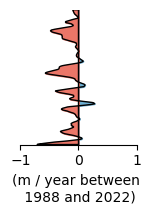

In [92]:
## All time plotting

# Set first and last entry to zero so we get clean graph outlines
ratesofchange_rolling_gdf["rate_time_sig_filtered"].iloc[0] = 0
ratesofchange_rolling_gdf["rate_time_sig_filtered"].iloc[-1] = 0

# Split out positive and negative rates so we can plot them individually
ratesofchange_positive_gdf = ratesofchange_rolling_gdf["rate_time_sig_filtered"].clip(0, np.inf)
ratesofchange_negative_gdf = ratesofchange_rolling_gdf["rate_time_sig_filtered"].clip(-np.inf, 0)

# Plot negative rates in red, positive in blue
fig, ax = plt.subplots(figsize=(1.5, 1.75))#5))#7))
ax.fill_betweenx(
    ratesofchange_positive_gdf.index, 0, ratesofchange_positive_gdf, color="#6caed1"
)
ax.fill_betweenx(
    ratesofchange_negative_gdf.index, ratesofchange_negative_gdf, 0, color="#eb7668"
)
ax.plot(
    ratesofchange_rolling_gdf["rate_time_sig_filtered"],
    ratesofchange_rolling_gdf.index,
    color="black",
    linewidth=1,
)

# Add vertical axis line
ax.axvline(0, color="black", linewidth=1)

# Styling
ax.set_xlim(-1, 1)
ax.set_ylim(min_coord, max_coord)
ax.set_xticks(ticks=[-1, 0, 1])
ax.set_xlabel("(m / year between \n 1988 and 2022)")
ax.spines[["top", "left", "right"]].set_visible(False)
ax.tick_params(top=False, left=False, labelleft=False, labeltop=False)

# Export
fig.savefig("/home/jovyan/dev/dea-notebooks/Testing/all_time_sig_time_filtered_all_GBR_mngt_area4.svg", bbox_inches="tight", transparent=True)

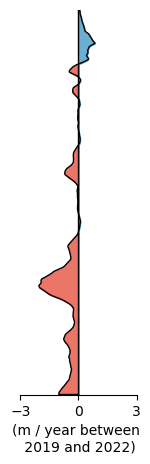

In [99]:
## Epoch plotting (without outlier removal - unlike original rate_time method)

# Set first and last entry to zero so we get clean graph outlines
ratesofchange_rolling_gdf['2019-2022_epoch_rate_time_sig_filtered'].iloc[0] = 0
ratesofchange_rolling_gdf['2019-2022_epoch_rate_time_sig_filtered'].iloc[-1] = 0

# Split out positive and negative rates so we can plot them individually
ratesofchange_positive_gdf = ratesofchange_rolling_gdf['2019-2022_epoch_rate_time_sig_filtered'].clip(0, np.inf)
ratesofchange_negative_gdf = ratesofchange_rolling_gdf['2019-2022_epoch_rate_time_sig_filtered'].clip(-np.inf, 0)

# Plot negative rates in red, positive in blue
fig, ax = plt.subplots(figsize=(1.5, 5))#5))#7))
ax.fill_betweenx(
    ratesofchange_positive_gdf.index, 0, ratesofchange_positive_gdf, color="#6caed1"
)
ax.fill_betweenx(
    ratesofchange_negative_gdf.index, ratesofchange_negative_gdf, 0, color="#eb7668"
)
ax.plot(
    ratesofchange_rolling_gdf['2019-2022_epoch_rate_time_sig_filtered'],
    ratesofchange_rolling_gdf.index,
    color="black",
    linewidth=1,
)

# Add vertical axis line
ax.axvline(0, color="black", linewidth=1)

# Styling
ax.set_xlim(-1, 1)
ax.set_ylim(min_coord, max_coord)
ax.set_xticks(ticks=[-3, 0, 3])
ax.set_xlabel("(m / year between \n 2019 and 2022)")
ax.spines[["top", "left", "right"]].set_visible(False)
ax.tick_params(top=False, left=False, labelleft=False, labeltop=False)

# Export
fig.savefig("/home/jovyan/dev/dea-notebooks/Testing/2019_to_2022_sig_time_filtered_all_GBR_mngt_area4_long.svg", bbox_inches="tight", transparent=True)

In [113]:
ratesofchange_gdf.to_csv("/home/jovyan/dev/dea-notebooks/Testing/DEACoastlines_ratesofchange_GBR_mngt_area_all.csv")

## Tabular summaries

In [322]:
region = 'GBR_mainland'

In [323]:
## Baseline comparison stats for mainland polygons
v1 = ratesofchange_gdf['rate_time_sig_filtered'].values
v2 = ratesofchange_gdf['2019-2022_epoch_rate_time_sig_filtered'].values

rel = ttest_rel(v1,v2)
rel

TtestResult(statistic=12.379691828838938, pvalue=3.493990938724498e-35, df=159705)

In [324]:
ratetimemean = ratesofchange_gdf['rate_time_sig_filtered'].mean().round(2)
ratetimestd = round(ratesofchange_gdf['rate_time_sig_filtered'].std(),2)
epochmean = ratesofchange_gdf['2019-2022_epoch_rate_time_sig_filtered'].mean().round(2)
epochstd = round(ratesofchange_gdf['2019-2022_epoch_rate_time_sig_filtered'].std(),2)

# Append new row to dataframe
StatSummary.loc[len(StatSummary.index)] =          [f'{ratetimemean} ({ratetimestd})', 
                                                   f'{epochmean} ({epochstd})',
                                                   rel.pvalue.round(2),
                                                   round(rel.statistic,2),
                                                   rel.df]
## Update index label
StatSummary.rename(index={StatSummary.loc[len(StatSummary.index)-1].name:region},inplace=True)

In [325]:
region = 'GBR_offshore'

In [326]:
## Baseline comparison stats for offshore polygons
v1 = ratesofchange_gdf_offshore['rate_time_sig_filtered'].values
v2 = ratesofchange_gdf_offshore['2019-2022_epoch_rate_time_sig_filtered'].values

rel = ttest_rel(v1,v2)
rel


TtestResult(statistic=1.4388957634859312, pvalue=0.15018509216977466, df=62172)

In [327]:

ratetimemean = ratesofchange_gdf_offshore['rate_time_sig_filtered'].mean().round(2)
ratetimestd = round(ratesofchange_gdf_offshore['rate_time_sig_filtered'].std(),2)
epochmean = ratesofchange_gdf_offshore['2019-2022_epoch_rate_time_sig_filtered'].mean().round(2)
epochstd = round(ratesofchange_gdf_offshore['2019-2022_epoch_rate_time_sig_filtered'].std(),2)

## Run once as the master dataframe
# data = {
#         '1988-2022':f'{ratetimemean} ({ratetimestd})', 
#         '2019-2022':f'{epochmean} ({epochstd})',
#         'pvalue (1988-2022 vs 2019-2022)':rel.pvalue,
#         'tstat (1988-2022 vs 2019-2022)':round(rel.statistic,2),
#         'df (1988-2022 vs 2019-2022)':rel.df
#         }
# StatSummary = pd.DataFrame(data, index=[region]) 

# Append new row to dataframe
StatSummary.loc[len(StatSummary.index)] =          [f'{ratetimemean} ({ratetimestd})', 
                                                   f'{epochmean} ({epochstd})',
                                                   round(rel.pvalue,2),
                                                   round(rel.statistic,2),
                                                   rel.df
                                                  ]
                                          
## Update index label
StatSummary.rename(index={StatSummary.loc[len(StatSummary.index)-1].name:region},inplace=True)
StatSummary

,1988-2022,2019-2022,pvalue (1988-2022 vs 2019-2022),tstat (1988-2022 vs 2019-2022),df (1988-2022 vs 2019-2022)
Aus,-0.08 (1.51),-0.67 (4.97),0.000000e+00,102.23,823484.0
Far_North_mainland,-0.08 (0.95),0.13 (2.74),1.503552e-45,-14.19,34688.0
Far_North_offshore,0.08 (0.45),0.12 (3.72),3.199401e-01,-0.99,9574.0
Cairns_Cooktown_mainland,0.05 (0.53),-0.13 (1.71),0.000000e+00,13.66,19883.0
Cairns_Cooktown_offshore,0.04 (0.35),-0.12 (1.24),0.000000e+00,6.12,2681.0
Townsville_Whitsunday_mainland,-0.09 (1.7),-0.64 (4.33),0.000000e+00,25.22,38832.0
Townsville_Whitsunday_offshore,0.07 (0.82),-0.11 (1.32),0.000000e+00,19.41,24335.0
Mackay_Capricorn_mainland,-0.22 (1.45),-0.32 (5.96),0.000000e+00,3.96,66026.0
Mackay_Capricorn_offshore,0.04 (1.19),0.15 (6.39),2.000000e-02,-2.28,25579.0
GBR_mainland,-0.12 (1.35),-0.28 (4.62),0.000000e+00,12.38,159705.0


In [328]:
StatSummary.to_csv("/home/jovyan/dev/dea-notebooks/Testing/StatSummary.csv")

In [329]:
region = 'GBR'

In [330]:
v1 = ratesofchange_gdf['rate_time_sig_filtered'].values
v2 = ratesofchange_gdf_offshore['rate_time_sig_filtered'].values

rel = ttest_ind(v1,v2,equal_var=False)
rel

Ttest_indResult(statistic=-36.53387361093294, pvalue=5.044564058668669e-291)

In [331]:
v1 = ratesofchange_gdf['2019-2022_epoch_rate_time_sig_filtered'].values
v2 = ratesofchange_gdf_offshore['2019-2022_epoch_rate_time_sig_filtered'].values

rel2 = ttest_ind(v1,v2,equal_var=False)
rel2

Ttest_indResult(statistic=-14.463872977153086, pvalue=2.2508512866638335e-47)

In [332]:
## Capture statistical significance in onshore vs offshore regions

## Run once as master dataframe
# data = {
#         'Onshore vs Offshore (1988-2022) tstat': rel.statistic.round(2),
#         'Onshore vs Offshore (1988-2022) pvalue': rel.pvalue.round(2),
#         'Onshore vs Offshore (2019-2022) tstat': rel2.statistic.round(2),
#         'Onshore vs Offshore (2019-2022) pvalue': rel2.pvalue.round(2)
#         }
# OnOffshoreSummary = pd.DataFrame(data, index=[region])

## Append new row to dataframe
OnOffshoreSummary.loc[len(OnOffshoreSummary.index)] = [rel.statistic.round(2),
                                                       rel.pvalue.round(2),
                                                       rel2.statistic.round(2),
                                                       rel2.pvalue.round(2)]
OnOffshoreSummary.rename(index={OnOffshoreSummary.loc[len(OnOffshoreSummary.index)-1].name:region}, inplace=True)
                                                       


In [333]:
OnOffshoreSummary

,Onshore vs Offshore (1988-2022) tstat,Onshore vs Offshore (1988-2022) pvalue,Onshore vs Offshore (2019-2022) tstat,Onshore vs Offshore (2019-2022) pvalue
Cairns_Cooktown,1.11,0.27,-0.35,0.72
Far_Northern,-23.65,0.00,0.36,0.72
Townsville_Whitsunday,-15.74,0.00,-22.83,0.00
Mackay_Capricorn,-28.21,0.00,-10.06,0.00
GBR,-36.53,0.00,-14.46,0.00


In [334]:
OnOffshoreSummary.to_csv("/home/jovyan/dev/dea-notebooks/Testing/OnOffshoreSummary.csv")